<a href="https://www.kaggle.com/code/naelaqel/data-processing-performance-benchmark?scriptVersionId=259268345" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Data Processing Performance Benchmark: Pandas vs Polars vs DuckDB
## Introduction
### Overview

This notebook benchmarks the performance of three popular data processing tools for common data science operations:

- **[Pandas](https://pandas.pydata.org/docs/)**: The traditional Python data analysis library, widely adopted but single-threaded
- **[Polars](https://docs.pola.rs/api/python/stable/reference/index.html)**: A modern DataFrame library implemented in Rust with parallel processing capabilities  
- **[DuckDB](https://duckdb.org/docs/stable/)**: An in-process SQL OLAP database optimized for analytical workloads

### Dataset

We use a synthetic e-commerce relational dataset available [here](https://www.kaggle.com/datasets/naelaqel/synthetic-e-commerce-relational-dataset) containing 5 tables:
- `customers` 
- `orders`
- `order_items`
- `products`
- `product_reviews`

The Visual EDR
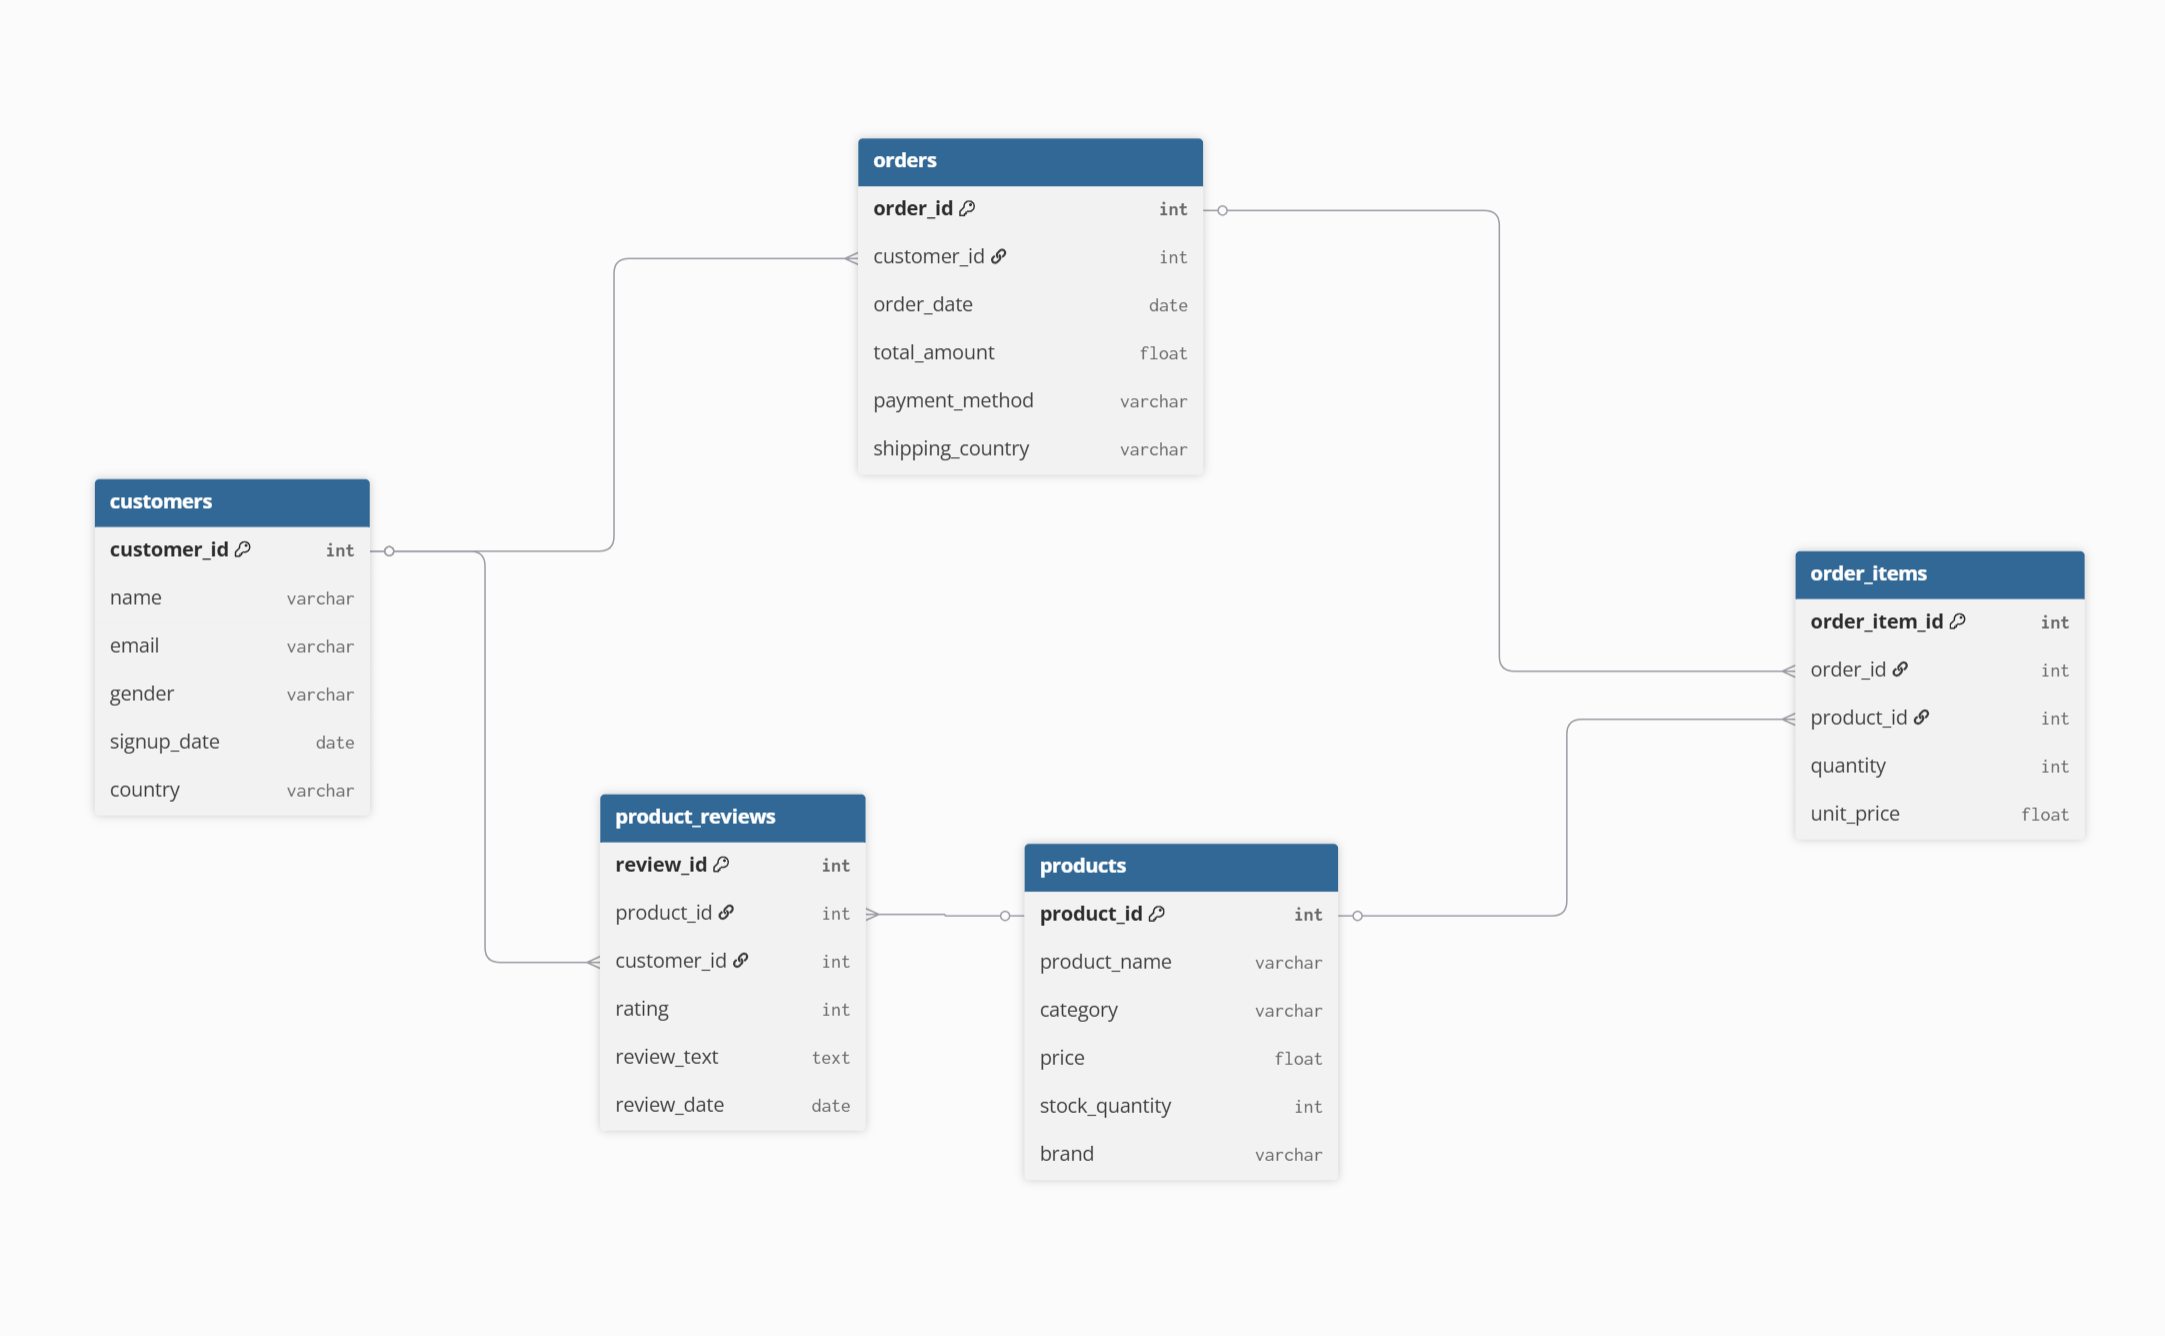


### Methodology of testing
- **Operations Tested**
    1. **File Loading**: Reading individual files into memory with default parameters, we will use these functions:
        - Pandas: [read_csv()](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html#pandas.read_csv) and [read_parquet()](https://pandas.pydata.org/docs/reference/api/pandas.read_parquet.html#pandas.read_parquet)
        - Polars: [read_csv()](https://docs.pola.rs/api/python/stable/reference/api/polars.read_csv.html) and [read_parquet()](https://docs.pola.rs/api/python/stable/reference/api/polars.read_parquet.html#polars.read_parquet)
        - DuckDB: we will read directly from the files' path, for reference we can also use [read_csv()](https://duckdb.org/docs/stable/data/csv/overview.html#csv-functions) and [read_parquet()](https://duckdb.org/docs/stable/data/parquet/overview) if we want to specify parameters.   
    2. **Join Operations**: Complex multi-table joins combining all 5 tables, we will left join `order_items -> orders -> customers -> products -> product_reviews` for all tools using:
        - Pandas: [merge()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html#pandas.DataFrame.merge)
        - Polars: [join()](https://docs.pola.rs/api/python/stable/reference/dataframe/api/polars.DataFrame.join.html)
        - DuckDB: Normal SQL left joins   

- **File Formats**
    1. **CSV**: Text-based format, human-readable but larger file sizes
    2. **Parquet**: Columnar binary format, optimized for analytics

- **Key Performance Indicators (KPIs)**
    1. **Primary Metric**: Execution time in seconds using [time.perf_counter()](https://docs.python.org/3/library/time.html#time.perf_counter)
    2. **Derived Metrics**: Speedup ratios calculated as:
        - `polars_to_pandas_speedup_ratio = pandas_time / polars_time`
        - `duckdb_to_pandas_speedup_ratio = pandas_time / duckdb_time` 
        - `duckdb_to_polars_speedup_ratio = polars_time / duckdb_time`

 > ***Values > 1.0 indicate the alternative tool is faster than the baseline***

- **Implementation Notes**
    - DuckDB approach: Reads files directly without loading into memory first
    - Pandas/Polars approach: Loads files into memory, then performs operations (and calculate the time for only joining (not loading))
    - For DuckDB and Polars, we measure only the initial data loading/parsing time without converting to DataFrames. Both tools have methods to convert their native objects to DataFrames, but we exclude this conversion step to measure pure I/O and parsing performance rather than materialization overhead. This approach provides a fairer comparison of each tool's core file reading capabilities. 

### Important Disclaimers

**Performance results may vary slightly between runs** due to:
- System resource availability
- Background processes
- Memory caching effects
- CPU thermal throttling

For production decisions, consider running multiple iterations and taking averages for more stable measurements.
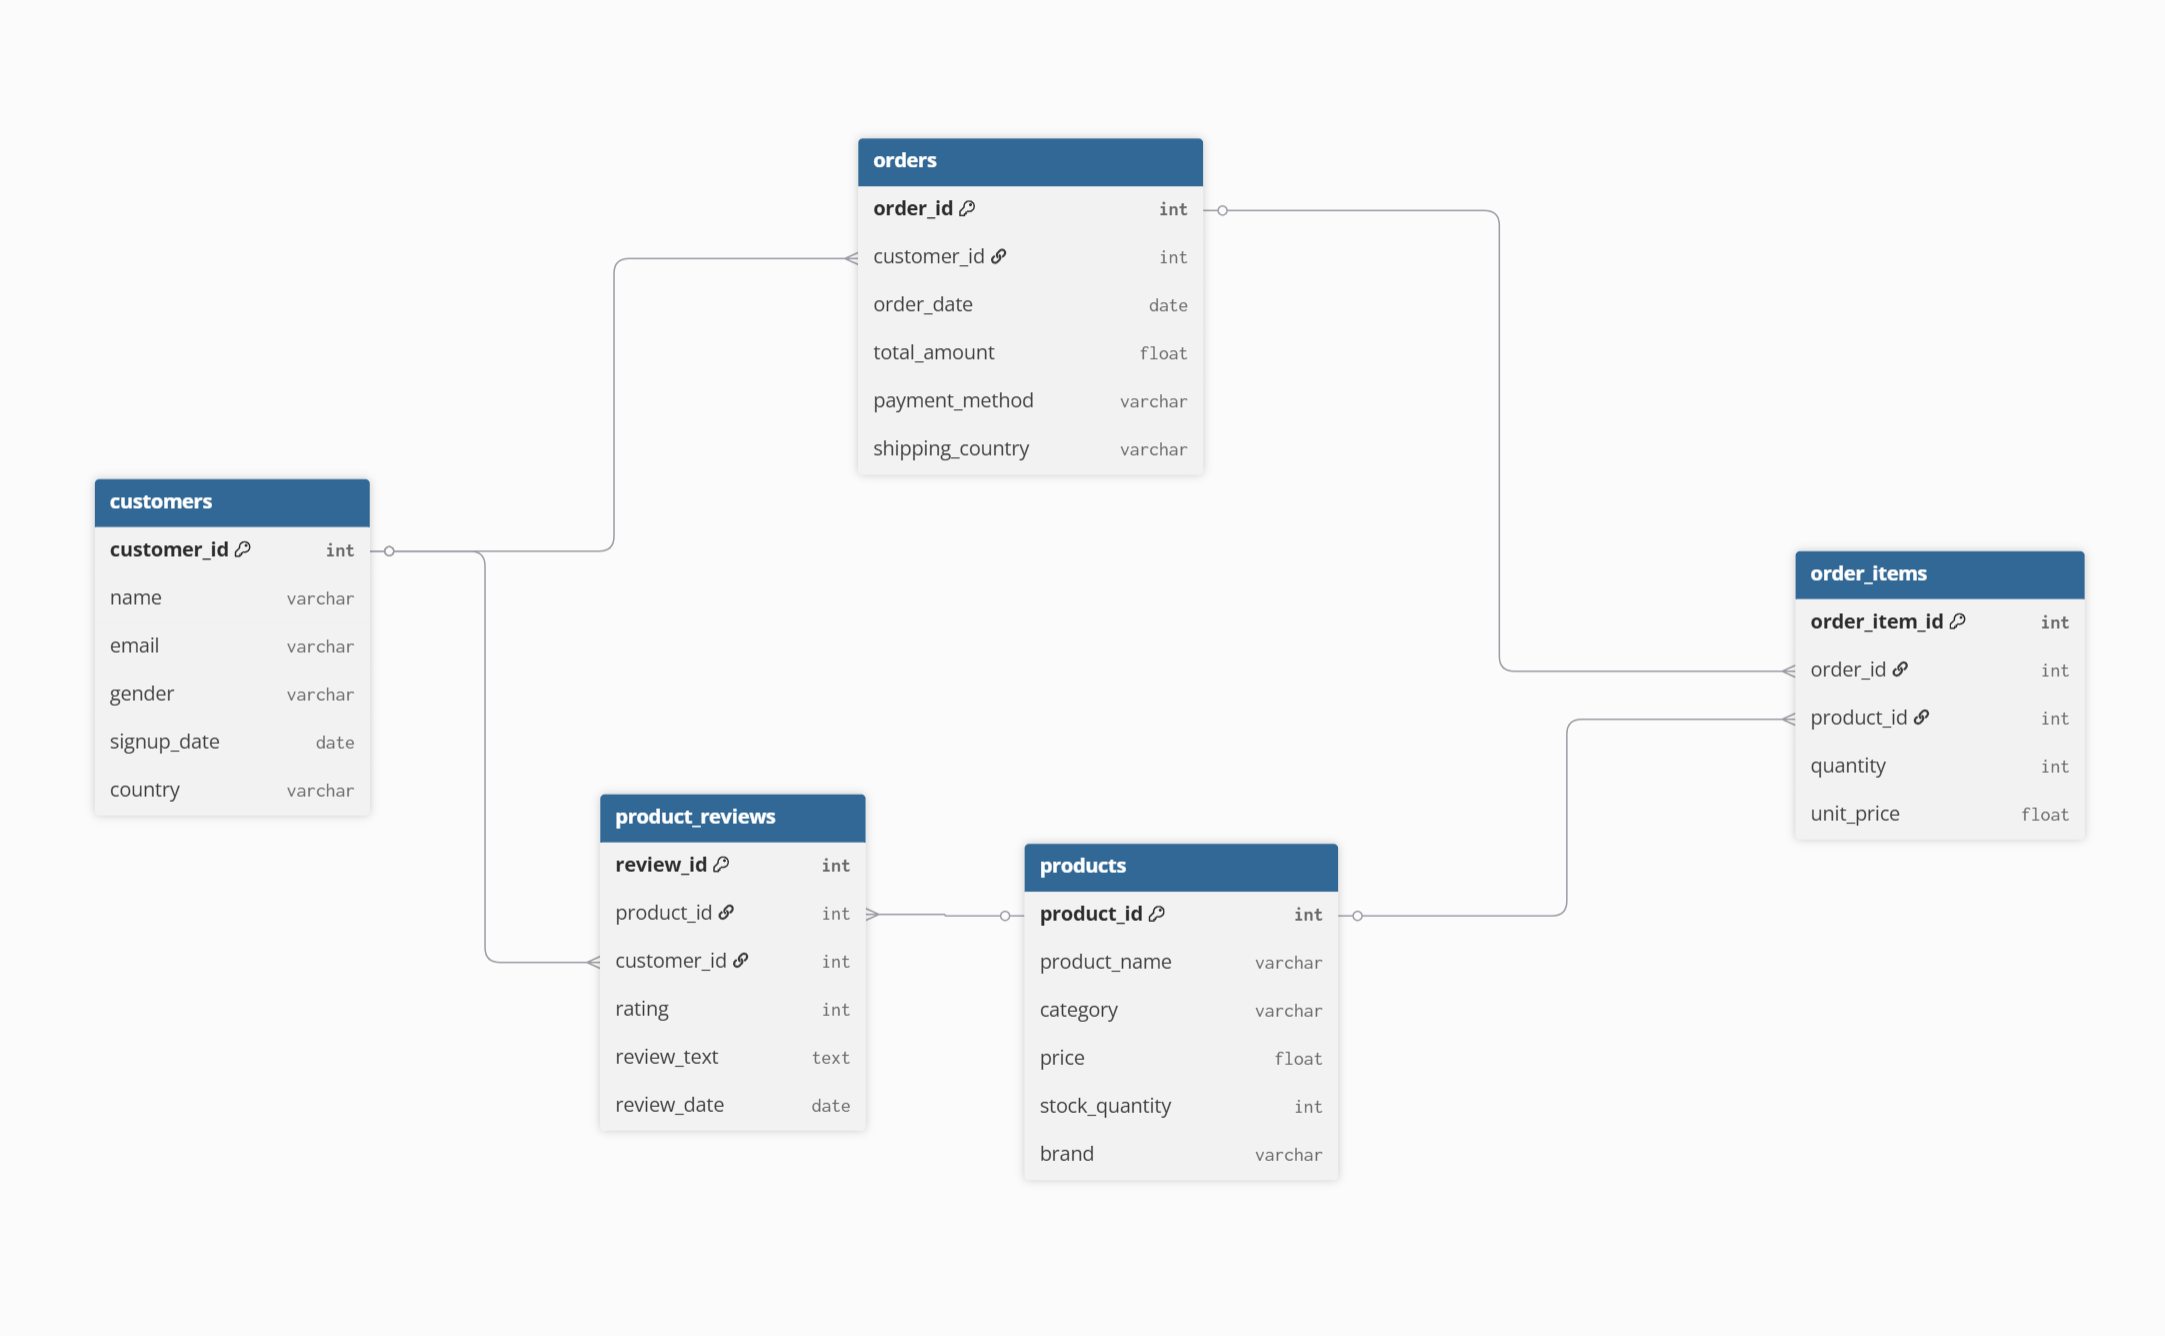

## Setup, Configurations and Defining functions
### Setup and Dependencies

First, let's install and import the required packages

In [1]:
# Install required packages
!pip install -qq pandas
!pip install -qq duckdb
!pip install -qq polars

In [2]:
# import modules
import pandas as pd
import polars as pl
import duckdb
import time

### Configuration and Setup

Define the test parameters and initialize our benchmarking environment

In [3]:
# Define benchmark parameters
files = {'customers', 'orders', 'order_items', 'products', 'product_reviews'}  # Dataset files to test
tools = {'pandas', 'polars', 'duckdb'}    # Data processing tools to compare
input_formats = {'csv', 'parquet'}    # File formats to benchmark
path = '/kaggle/input/synthetic-e-commerce-relational-dataset'   # Path to dataset

# Initialize DuckDB connection for SQL-based operations
con = duckdb.connect()

### Sample of each tool output
Here we will just see an example for each tool's output, we will show the first 5 rows of the `products` table

In [4]:
# pandas
pd.read_csv(f'{path}/csv/products.csv').head()

,product_id,product_name,category,price,stock_quantity,brand
0,1,Plan Get,Books,278.27,533,BrandA
1,2,Field Yet,Beauty,479.56,5,BrandA
2,3,Technology Her,Books,332.59,268,BrandA
3,4,Decade Pick,Toys,198.16,944,BrandB
4,5,Finally Develop,Beauty,307.60,862,BrandC


In [5]:
# polars
pl.read_csv(f'{path}/csv/products.csv').head()

product_id,product_name,category,price,stock_quantity,brand
i64,str,str,f64,i64,str
1,"""Plan Get""","""Books""",278.27,533,"""BrandA"""
2,"""Field Yet""","""Beauty""",479.56,5,"""BrandA"""
3,"""Technology Her""","""Books""",332.59,268,"""BrandA"""
4,"""Decade Pick""","""Toys""",198.16,944,"""BrandB"""
5,"""Finally Develop""","""Beauty""",307.6,862,"""BrandC"""


In [6]:
# DuckDB
con.query(f"select * from '{path}/csv/products.csv' limit 5")

┌────────────┬─────────────────┬──────────┬────────┬────────────────┬─────────┐
│ product_id │  product_name   │ category │ price  │ stock_quantity │  brand  │
│   int64    │     varchar     │ varchar  │ double │     int64      │ varchar │
├────────────┼─────────────────┼──────────┼────────┼────────────────┼─────────┤
│          1 │ Plan Get        │ Books    │ 278.27 │            533 │ BrandA  │
│          2 │ Field Yet       │ Beauty   │ 479.56 │              5 │ BrandA  │
│          3 │ Technology Her  │ Books    │ 332.59 │            268 │ BrandA  │
│          4 │ Decade Pick     │ Toys     │ 198.16 │            944 │ BrandB  │
│          5 │ Finally Develop │ Beauty   │  307.6 │            862 │ BrandC  │
└────────────┴─────────────────┴──────────┴────────┴────────────────┴─────────┘

### Define Loading Functions

Create a dictionary of loading functions for each tool and file format combination

In [7]:
# Define loading functions for each tool and file format combination
load_functions = {
    'csv': {
        'pandas': lambda file: pd.read_csv(file),
        'polars': lambda file: pl.read_csv(file),
        'duckdb': lambda file: con.query(f"select * from '{file}'")
        },
    'parquet': {
        'pandas': lambda file: pd.read_parquet(file),
        'polars': lambda file: pl.read_parquet(file),
        'duckdb': lambda file: con.query(f"select * from '{file}'")
        }
}

### Define Join Functions

Create join functions that perform the same multi-table join operation using each tool's syntax

In [8]:
# Define join functions that perform the same multi-table join using each tool's syntax
join_functions = {
    # Pandas: uses merge() method with explicit join keys and suffixes (datasets will be inside dfs dictionary)
    'pandas': lambda dfs: dfs['order_items'] \
        .merge(dfs['orders'].merge(dfs['customers'], how='left', on='customer_id'), how='left', on='order_id') \
        .merge(dfs['products'], how='left', on='product_id') \
        .merge(dfs['product_reviews'], on=['product_id', 'customer_id'], how='left', suffixes=('', '_review')),

    # Polars: uses join() method with suffix parameter for column name conflicts (datasets will be inside dfs dictionary)
    'polars': lambda dfs: dfs['order_items'] \
        .join(dfs['orders'].join(dfs['customers'], how='left', on='customer_id'), how='left', on='order_id') \
        .join(dfs['products'], how='left', on='product_id') \
        .join(dfs['product_reviews'], on=['product_id', 'customer_id'], how='left', suffix='_review'),

    # DuckDB: uses SQL syntax for joins directly on files (so we wnat the input_format to read the correct file)
    'duckdb': lambda input_format: con.query(f'''
        select * from '{path}/{input_format}/order_items.{input_format}' 
        left join '{path}/{input_format}/orders.{input_format}' using(order_id) 
        left join '{path}/{input_format}/customers.{input_format}' using(customer_id) 
        left join '{path}/{input_format}/products.{input_format}' using(product_id) 
        left join '{path}/{input_format}/product_reviews.{input_format}' using(product_id, customer_id)
    ''')
} 

### Performance Profiling Utility

Define a helper function to measure execution time

In [9]:
# make time_profile function to return time spent in function
def time_profile(func):
    """Measures execution time for a function using high-precision timer."""  
    start = time.perf_counter() # timer start
    func()                      # execute function
    end = time.perf_counter()   # timer end
    
    return end - start

-----
## File Loading Benchmark
Now let's benchmark the performance of loading operations across the three tools.

### Initialize Results Structure

Create a nested dictionary to store our benchmark results, the structure is `load_results[input_format][file][tool] = execution_time`

In [10]:
# Structure: `load_results[input_format][file][tool] = execution_time`
load_results = {}

for input_format in input_formats:
    for tool in tools:
        for file in files:
            if input_format not in load_results:
                load_results[input_format] = {}
            if file not in load_results[input_format]:
                load_results[input_format][file] = {}
            if tool not in load_results[input_format][file]:
                load_results[input_format][file][tool] = {}

### Run Loading Benchmarks

Execute the benchmarks for each combination of file format, tool, and dataset

In [11]:
# Execute file loading benchmarks for each combination
for input_format in input_formats:
    for tool in tools:
        for file in files:
            # Measure time to load each file with each tool
            load_results[input_format][file][tool] = time_profile(
                lambda: load_functions[input_format][tool](f'{path}/{input_format}/{file}.{input_format}'))


### Process and Display Results

Convert results to a DataFrame and calculate speedup ratios




In [12]:
# Convert nested dictionary results to flat list for DataFrame creation
to_list = []

for input_format in load_results.keys():
    for file in load_results[input_format].keys():
        for tool in load_results[input_format][file].keys():
            to_list.append([input_format, file, tool, load_results[input_format][file][tool]])

# Create DataFrame from results
df = pd.DataFrame(to_list, columns=['input_format', 'file', 'tool', 'period_sec'])

# Pivot table with tools as columns for side-by-side comparison
df_summary = df.pivot_table(index=['input_format', 'file'], columns='tool', values='period_sec')[['pandas', 'polars', 'duckdb']]

# Calculate speedup ratios
df_summary['polars_to_pandas_speedup_ratio'] = round(df_summary['pandas'] / df_summary['polars'], 2)
df_summary['duckdb_to_pandas_speedup_ratio'] = round(df_summary['pandas'] / df_summary['duckdb'], 2)
df_summary['duckdb_to_polars_speedup_ratio'] = round(df_summary['polars'] / df_summary['duckdb'], 2)

# Display detailed results
df_summary

tool                             pandas    polars    duckdb  \
input_format file                                             
csv          customers         4.115109  1.822893  0.152676   
             order_items      11.490190  4.627600  0.029305   
             orders           10.077554  0.734371  0.095147   
             product_reviews  12.712844  0.343868  0.101544   
             products          0.041947  0.006496  0.031891   
parquet      customers         2.077993  0.268748  0.004912   
             order_items       2.486125  0.467749  0.001885   
             orders            1.461580  0.267410  0.001883   
             product_reviews   3.243509  0.550355  0.001065   
             products          0.018186  0.004464  0.001281   

tool                          polars_to_pandas_speedup_ratio  \
input_format file                                              
csv          customers                                  2.26   
             order_items                                2.48   
             orders                                    13.72   
             product_reviews                           36.97   
             products                                   6.46   
parquet      customers                                  7.73   
             order_items                                5.32   
             orders                                     5.47   
             product_reviews                            5.89   
             products                                   4.07   

tool                          duckdb_to_pandas_speedup_ratio  \
input_format file                                              
csv          customers                                 26.95   
             order_items                              392.09   
             orders                                   105.92   
             product_reviews                          125.20   
             products                                   1.32   
parquet      customers                                423.08   
             order_items                             1318.92   
             orders                                   776.18   
             product_reviews                         3046.46   
             products                                  14.20   

tool                          duckdb_to_polars_speedup_ratio  
input_format file                                             
csv          customers                                 11.94  
             order_items                              157.91  
             orders                                     7.72  
             product_reviews                            3.39  
             products                                   0.20  
parquet      customers                                 54.72  
             order_items                              248.15  
             orders                                   142.01  
             product_reviews                          516.92  
             products                                   3.48

--------

## Join Operations Benchmark

Now let's benchmark the performance of join operations across the three tools

### Initialize Results Structure

Create a nested dictionary to store our benchmark results, the structure is `join_results[input_format][tool] = execution_time`

In [13]:
# Structure: `join_results[input_format][tool] = execution_time`
join_results = {}

for input_format in input_formats:
    for tool in tools:
        if input_format not in join_results:
            join_results[input_format] = {}
        if tool not in join_results[input_format]:
            join_results[input_format][tool] = {}

### Run Join Benchmarks

Execute join benchmarks with different approaches for DuckDB (direct file access) vs others (in-memory operations) where we are loading the files first to `dfs` so the time calculations will be for the `join` only.

Also we re-write on `dfs` to save memory

In [14]:
# Execute join benchmarks with different strategies for different tools
for input_format in input_formats:   
    for tool in tools:
        if tool != 'duckdb':
            # For pandas and polars: first load all files into memory, then perform joins
            dfs = {file: load_functions[input_format][tool](f'{path}/{input_format}/{file}.{input_format}') for file in files}
            join_results[input_format][tool] = time_profile(lambda: join_functions[tool](dfs))
        else:
            # For DuckDB: perform joins directly on files without loading into memory first
            join_results[input_format][tool] = time_profile(lambda: join_functions[tool](input_format))

# Clear memory
dfs = dict()

### Process Join Results

Convert join benchmark results to DataFrame and calculate speedup ratios:

In [15]:
# Convert join results to DataFrame format
to_list_join = []

for input_format in join_results.keys():
    for tool in join_results[input_format].keys():
        to_list_join.append([input_format, tool, join_results[input_format][tool]])

# Create DataFrame from results
df_join = pd.DataFrame(to_list_join, columns=['input_format', 'tool', 'period_sec'])

# Pivot table with tools as columns for side-by-side comparison
df_join_summary = df_join.pivot_table(index=['input_format'], columns='tool', values='period_sec')[['pandas', 'polars', 'duckdb']]

# Calculate speedup ratios for join operations
df_join_summary['polars_to_pandas_speedup_ratio'] = round(df_join_summary['pandas'] / df_join_summary['polars'], 2)
df_join_summary['duckdb_to_pandas_speedup_ratio'] = round(df_join_summary['pandas'] / df_join_summary['duckdb'], 2)
df_join_summary['duckdb_to_polars_speedup_ratio'] = round(df_join_summary['polars'] / df_join_summary['duckdb'], 2)

# Display join benchmark results
df_join_summary

tool,pandas,polars,duckdb,polars_to_pandas_speedup_ratio,duckdb_to_pandas_speedup_ratio,duckdb_to_polars_speedup_ratio
input_format,,,,,,
csv,54.618929,9.039762,0.385153,6.04,141.81,23.47
parquet,61.953196,8.703478,0.022717,7.12,2727.18,383.13
